<a href="https://colab.research.google.com/github/zhiyuan-95/db-vae/blob/main/comet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install comet_ml --quiet
import comet_ml
from comet_ml import API
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.9/780.9 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 59.0 MB/s eta 0:00:00


what I am trying to do is that I want to prove that the given method can produce a better standard cnn. which means that the validation score would reduce as the increasing epoch.

In [66]:
from functools import partial
EPOCH_PARAM_NAMES = {'batch_size', 'learning_rate', 'smoothing_fact'}

def _experiment_to_row(e, param_names=None, model=None):
    """
    Build one row for an experiment.

    - Define best_step from the 'val' metric summary (stepMax).
    - All metrics (WM/WF/BM/BF, val, dbvae) are taken at that best_step.
    - When model == 'dbvae-final':
        record: val_WM, val_WF, val_BM, val_BF, val, dbvae.
    - When model != 'dbvae-final':
        record: val, dbvae  (both at best_step).
    """
    metric_summaries = {sm['name']: sm for sm in e.get_metrics_summary()}

    def mget_summary(name, key, default=None):
        sm = metric_summaries.get(name)
        if sm is None:
            return default
        return sm.get(key, default)

    # ---------- 1) Best step / epoch from 'val' ----------
    best_step = mget_summary('val', 'stepMax', default=None)
    best_epoch = float('nan')

    if best_step is not None:
        try:
            best_step = int(best_step)
            best_epoch = best_step + 1  # 1-based
        except (TypeError, ValueError):
            best_step = None

    best_val = mget_summary('val', 'valueMax', default=float('nan'))
    try:
        best_val = float(best_val)
    except (TypeError, ValueError):
        best_val = float('nan')

    stop_epoch_raw = mget_summary('val', 'stepCurrent', default=None)
    if stop_epoch_raw is not None:
        try:
            stop_epoch_val = int(stop_epoch_raw) + 1
        except (TypeError, ValueError):
            stop_epoch_val = float('nan')
    else:
        stop_epoch_val = float('nan')

    row = {
        "exp_key": getattr(e, "key", None),
        "stop_epoch": stop_epoch_val,
        "best_val": best_val,
        "best_epoch": best_epoch,
    }

    # ---------- 2) Hyperparameters ----------
    allowed = set(param_names) if param_names is not None else EPOCH_PARAM_NAMES
    params = {}
    for p in e.get_parameters_summary():
        name = p.get("name")
        if name in allowed:
            params[name] = p.get("valueCurrent", None)

    params.update(row)

    # If we don't know the best_step, we can't align metrics → return NaNs
    if best_step is None:
        # We still want val/dbvae columns so downstream code doesn't explode
        params['val'] = best_val
        params['dbvae'] = float('nan')
        if model == 'dbvae-final':
            params['val_WM'] = params['val_WF'] = float('nan')
            params['val_BM'] = params['val_BF'] = float('nan')
        return params

    # ---------- 3) Collect metrics at best_step ----------
    metrics_at_best = {}

    # What names we care about
    if model == 'dbvae-final':
        needed = {'val_WM', 'val_WF', 'val_BM', 'val_BF', 'val'}
    else:
        # for non-final models we want val + some fairness metric (dbval/bias/dbvae)
        needed = {'val', 'dbval', 'bias', 'dbvae'}

    for m in e.get_metrics():
        name = m.get('metricName')
        if name not in needed:
            continue

        step_raw = m.get('step')
        if step_raw is None:
            continue
        try:
            step = int(step_raw)
        except (TypeError, ValueError):
            continue

        if step != best_step:
            continue

        val_raw = m.get('metricValue')
        try:
            metrics_at_best[name] = float(val_raw)
        except (TypeError, ValueError):
            metrics_at_best[name] = float('nan')

    # ---------- 4) Fill record depending on model ----------
    if model == 'dbvae-final':
        # group metrics at best
        val_WM = metrics_at_best.get('val_WM', float('nan'))
        val_WF = metrics_at_best.get('val_WF', float('nan'))
        val_BM = metrics_at_best.get('val_BM', float('nan'))
        val_BF = metrics_at_best.get('val_BF', float('nan'))
        val_overall = metrics_at_best.get('val', best_val)

        params['val_WM'] = val_WM
        params['val_WF'] = val_WF
        params['val_BM'] = val_BM
        params['val_BF'] = val_BF
        params['val']   = val_overall

        # dbvae = max(group_means) - min(group_means) at best_step
        groups = [v for v in [val_WM, val_WF, val_BM, val_BF] if not np.isnan(v)]
        if groups:
            dbvae = max(groups) - min(groups)
        else:
            dbvae = float('nan')
        params['dbvae'] = dbvae

    else:
        # Non dbvae-final models: val at best_step + fairness metric at best_step
        val_overall = metrics_at_best.get('val', best_val)
        params['val'] = val_overall

        # Try dbval, then bias, then dbvae (whatever you logged)
        db_candidate = metrics_at_best.get('dbval')
        if db_candidate is None or np.isnan(db_candidate):
            db_candidate = metrics_at_best.get('bias')
        if db_candidate is None or np.isnan(db_candidate):
            db_candidate = metrics_at_best.get('dbvae', float('nan'))

        try:
            db_candidate = float(db_candidate)
        except (TypeError, ValueError):
            db_candidate = float('nan')

        params['dbvae'] = db_candidate

    return params


def get_param_metric_records(experiments, param_names=None, model=None):
    print('experiment record retrieving...')
    mapper = partial(_experiment_to_row, param_names=param_names, model=model)
    rows = list(map(mapper, experiments))
    df = pd.DataFrame(rows)
    df.index = df.index + 1
    return df


In [3]:
def plot(comet,record,y):
    if comet.model == 'dbvae':
        params = [
            ['batch_size', 'learning_rate'],
            ['smoothing_fac','latent_dim']
        ]
        for i in range(len(params)):
            fig, ax = plt.subplots(1, 2, figsize=(10, 4))
            for j in range(len(params[i])):
                ax[j].scatter(record[params[i][j]], record[y])
                ax[j].set_xlabel(params[i][j])
                ax[j].set_ylabel(y)
                ax[j].set_title(f"{params[i][j]} vs. {y}")
                ax[j].grid(True)
            plt.tight_layout(rect=[0, 0, 1, 0.98])
            plt.show()

    elif comet.model == 'standard':
        params = ['batch_size', 'learning_rate']
        fig, ax = plt.subplots(1, 2, figsize=(10, 4))
        for i in range(len(params)):
            ax[j].scatter(record[params[i][j]], record[y])
            ax[j].set_xlabel(params[i][j])
            ax[j].set_ylabel(y)
            ax[j].set_title(f"{params[i][j]} vs. {y}")
            ax[j].grid(True)
        for sub_ax in fig.get_axes():
            sub_ax.label_outer()
        plt.tight_layout(rect=[0, 0, 1, 0.98])
        plt.show()

In [55]:
# --- 1) pick representative trial per hyperparameter set ---
def pick_representatives(record: pd.DataFrame, by_params, measure):
    grouped = record.groupby(by_params, dropna=False)
    reps = []

    for params, group in grouped:
        vals = group['best_val']
        if vals.dropna().empty:
            continue

        if measure == "max":
            idx = vals.idxmax()

        elif measure == "median":
            med = vals.median()
            idx = (vals - med).abs().idxmin()

        else:
            raise ValueError(f"Unknown measure '{measure}'. Use 'max' or 'median'.")

        if pd.notna(idx):
            reps.append(idx)

    return reps



def metrics_at_epoch(exp, epoch, names=('loss_ema','val','dbval')):
    # build per-metric -> {step: value}
    store = {n: {} for n in names}
    for m in exp.get_metrics():
        name = m['metricName']
        if name in store:
            step = int(m['step'])
            store[name][step] = float(m['metricValue'])

    # Some notebooks log epoch starting at 0, some at 1.
    # Try exact epoch first; if missing, try epoch-1 as a fallback.
    out = {}
    for n in names:
        if epoch in store[n]:
            out[n] = store[n][epoch]
        elif (epoch - 1) in store[n]:
            out[n] = store[n][epoch - 1]
        else:
            out[n] = float('nan')
    return out

def build_summary(model,measure, by_params):
    print('generating summary....')
    record = model.record
    exps = model.experiments
    # Step 1: pick the representative trial (median best_val) for each hyperparameter group
    best_idx = pick_representatives(record, by_params, measure)
    # Step 2: define a helper function that will run on each record
    def get_metrics_for_row(row):
        # exp indices are 0-based, record indices are 1-based (from get_param_metric_records)
        exp = exps[row.name - 1]
        best_epoch = int(row['best_epoch'])
        best_val = float(row['best_val'])

        # Extract metrics at that epoch
        metrics = metrics_at_epoch(exp, best_epoch-1, names=('loss_ema','val','dbval'))
        return pd.Series({
            'exp_key': row['exp_key'],
            f'loss_at_{measure}': metrics['loss_ema'],
            f'val_at_{measure}': metrics['val'],
            f'dbval_at_{measure}': metrics['dbval'],
            'best_epoch': best_epoch,
            'best_val': best_val,
        })

    # Step 3: apply `map` (or technically pandas `apply`) to selected records
    selected_records = record.loc[best_idx]
    metrics_summary = selected_records.apply(get_metrics_for_row, axis=1)

    # Step 4: merge param columns + metrics summary
    param_cols = record.columns.intersection(by_params)
    summary_df = pd.concat([selected_records[param_cols].reset_index(drop=True),
                            metrics_summary.reset_index(drop=True)], axis=1)

    return summary_df.sort_values(by=f'val_at_{measure}', ascending=False).reset_index(drop=True)

In [5]:
def get_metric_names(model):
  metricName = []
  for x in model.experiments[0].get_metrics():
    if x['metricName'] not in metricName and x['metricName'][:3]!='sys':
      metricName.append(x['metricName'])
  print(sorted(metricName))

In [21]:
def project_name(c, name):
  name = f'{name}-c'
  for x in range(3):
    if len(str(c[x]))==1: name+=f'-{c[x]}'
    else: name+=f'-{str(c[x])[0]}-{str(c[x])[2:]}'
  return name


In [61]:
class comet():
  def __init__(self, model, measure, c=None, expmt=1):
      COMET_API_KEY = "ROr5Iwf4PjYLL2ZhtmHtYHhoP"
      self.api = API(COMET_API_KEY)
      self.workspace = "zhiyuan-jin"
      self.model = model

      if model == 'standard':
          self.projectName = "standard-p-3"
          self.params = ['batch_size', 'learning_rate']
      else:  # 'debiasing', 'dbvae-final', etc.
          self.projectName = project_name(c, model)
          self.params = ['batch_size', 'learning_rate', 'smoothing_fact']

      try:
          self.experiments = self.api.get(
              project_name=self.projectName,
              workspace=self.workspace
          )
      except Exception as e:
          print(
              f"Error: Could not find project '{self.projectName}' "
              f"in workspace '{self.workspace}'. Please check the project name and workspace in Comet ML."
          )
          raise e

      # >>> pass self.model here <<<
      self.record = get_param_metric_records(self.experiments, self.params, model=self.model)

      self.top_records = None
      self.summary = build_summary(self, measure, self.params)

  def delete_record_comet(self, keys):
    print('are you sure you want to delate following records?: ')
    for x in keys:
      print(x)
    answer = input('')
    if answer == 'yes':
      for key in keys:
        self.api.delete_experiment(key)
        print(f"Deleted experiment {key}")
      self.experiments = self.api.get(project_name=self.projectName, workspace="zhiyuan-jin")
      self.record = get_param_metric_records(self.experiments,self.params)
    else:
      print('not deleted')
  def plot_relation(self, x,y):
    if x == 'learning_rate': X = [float(l) for l in self.summary['learning_rate']]
    elif x == 'batch_size': X = [int(l) for l in self.summary['batch_size']]
    elif y == 'batch_size': Y = [int(l) for l in self.summary['batch_size']]
    else: X = self.summary[x]
    Y = self.summary[y]
    plt.figure(figsize=(10, 6))
    plt.scatter(X, Y)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(f"{x} vs. {y} across Experiments")
    plt.grid(True)
    plt.show()
  def delete_nan_validation(self, confirm=True):
      nan_columns = self.v.columns[self.v.iloc[-1].isna()]
      nan_exps = self.record.loc[nan_columns.to_list()]
      if nan_exps.empty:
          print("✅ No experiments with NaN validation found.")
          return
      print(f"⚠️ Found {len(nan_exps)} experiments with NaN validation:")
      print(nan_exps[['exp_key', 'exp_name', 'validation']])
      if not confirm:
          answer = 'yes'
      else:
          answer = input("Type 'yes' to confirm deletion: ")
      if answer.lower() == 'yes':
          for key in nan_exps['exp_key']:
              try:
                  self.api.delete_experiment(key)
                  print(f"Deleted experiment {key}")
              except Exception as e:
                  print(f"❌ Failed to delete {key}: {e}")
          # Refresh records
          self.experiments = self.api.get(project_name=self.projectName, workspace=self.workspace)
          self.record = get_param_metric_records(self.experiments, self.params)
          print("✅ Refresh complete. Updated experiment list loaded.")
      else:
          print("⏩ Deletion cancelled.")
  def loss_decompose(self,exp):
    total, classification,vae = [],[],[]
    for x in self.experiments[exp].get_metrics():
      if x['metricName']=='loss': total.append(float(x['metricValue']))
      elif x['metricName']=='classification': classification.append(float(x['metricValue']))
      elif x['metricName']=='vae': vae.append(float(x['metricValue']))
    plt.plot(total, label='Total Loss')
    plt.plot(classification, label='classification')
    plt.plot(vae, label='vae')
    plt.legend()
    plt.show()
  def val_trend(self,key):
    val, dbval = [],[]
    for x in self.api.get_experiment_by_key(key).get_metrics():
      if x['metricName']=='val': val.append(float(x['metricValue']))
      elif x['metricName']=='dbval': dbval.append(float(x['metricValue']))
    plt.plot(val, label='val')
    plt.plot(dbval, label='dbval')
    plt.legend()
    plt.show()
  def delete_incomplete_experiment_groups(self, expected_trials=3, confirm=True):
    """
    Delete all experiment trials for groups that contain fewer than expected_trials.

    A "group" means same (batch_size, learning_rate, smoothing_fact)
    depending on self.params.
    """

    # Step 1: count experiments per hyperparameter set
    group_counts = self.record.groupby(self.params)['exp_key'].count()

    # Step 2: find incomplete groups
    incomplete = group_counts[group_counts < expected_trials]

    if incomplete.empty:
        print(f"✅ All experiment groups have at least {expected_trials} trials.")
        return

    print("⚠️ Found incomplete groups (less than expected trials):")
    print(incomplete)

    # Step 3: collect all exp_keys belonging to incomplete groups
    keys_to_delete = []

    for params, _ in incomplete.items():
        batch = self.params
        # filter record rows matching these params
        mask = (self.record[batch[0]] == params[0])
        for i in range(1, len(batch)):
            mask &= (self.record[batch[i]] == params[i])
        keys_to_delete.extend(self.record[mask]['exp_key'].tolist())

    print("\nExperiments to be deleted:")
    for k in keys_to_delete:
        print(" -", k)

    # Step 4: confirmation
    if confirm:
        ans = input("\nType 'yes' to confirm deletion: ")
        if ans.lower() != "yes":
            print("❌ Deletion cancelled.")
            return

    # Step 5: delete through Comet API
    print("\nDeleting experiments...")
    for key in keys_to_delete:
        try:
            self.api.delete_experiment(key)
            print(f"Deleted {key}")
        except Exception as e:
            print(f"❌ Failed to delete {key}: {e}")

    # Step 6: refresh state
    self.experiments = self.api.get(project_name=self.projectName, workspace=self.workspace)
    self.record = get_param_metric_records(self.experiments, self.params)
    print("✅ Refresh complete.")


In [62]:
def get_epoch_avg_history(model, metric='dbval', smoothing_col='smoothing_fact'):
    """
    If smoothing_col exists in model.summary:
        return dict {smoothing_value: avg_traj_series}
    Else:
        return dict {'all': avg_traj_series}
    """
    has_smoothing = smoothing_col in model.summary.columns

    # -------------------------
    # Case 1: Standard CNN
    # -------------------------
    if not has_smoothing:
        print(f'standard cnn with {model.summary.shape[0]} reps...')
        trajectories = []
        for _, row in model.summary.iterrows():
            exp_key = row['exp_key']
            best_epoch = int(row['best_epoch'])

            try:
                exp = model.api.get_experiment_by_key(exp_key)
                metrics = exp.get_metrics()

                vals = {}
                for m in metrics:
                    if m['metricName'] == metric:
                        step = int(m['step'])
                        if step < best_epoch:
                            vals[step] = float(m['metricValue'])

                if vals:
                    trajectories.append(pd.Series(vals))

            except Exception as e:
                print(f"Failed to fetch metrics for {exp_key}: {e}")

        if trajectories:
            df = pd.concat(trajectories, axis=1)
            mean_traj = df.mean(axis=1).sort_index()
        else:
            mean_traj = pd.Series(dtype=float)

        return {'all': mean_traj}

    # -------------------------
    # Case 2: DBVAE (group by smoothing_fact)
    # -------------------------
    results = {}
    for sm_val, sm_group in model.summary.groupby(smoothing_col):
        print(f"Processing dbvae smoothing={sm_val} with {len(sm_group)} reps...")

        trajectories = []

        for _, row in sm_group.iterrows():
            exp_key = row['exp_key']
            best_epoch = int(row['best_epoch'])

            try:
                exp = model.api.get_experiment_by_key(exp_key)
                metrics = exp.get_metrics()

                vals = {}
                for m in metrics:
                    if m['metricName'] == metric:
                        step = int(m['step'])
                        if step < best_epoch:
                            vals[step] = float(m['metricValue'])

                if vals:
                    trajectories.append(pd.Series(vals))

            except Exception as e:
                print(f"Failed to fetch metrics for {exp_key}: {e}")

        if trajectories:
            df = pd.concat(trajectories, axis=1)
            mean_traj = df.mean(axis=1).sort_index()
        else:
            mean_traj = pd.Series(dtype=float)

        results[sm_val] = mean_traj

    return results

In [9]:
value = 'median'
standard = comet('standard', value)

experiment record retrieving...
generating summary....


In [10]:
#c =(1,0.2,0.0002)
c = (1,1,0.0002)
dbvae = comet('debiasing',value, c)

experiment record retrieving...
generating summary....


In [67]:
dbvae_final = comet('dbvae-final', value, c)

experiment record retrieving...
generating summary....


In [68]:
dbvae_final.record

,batch_size,learning_rate,smoothing_fact,exp_key,stop_epoch,best_val,best_epoch,val_WM,val_WF,val_BM,val_BF,val,dbvae
1,50,6.47E-4,0.6,1396e5fa03c84147830d5f35baf8e9d4,6,0.739312,3,0.758882,0.793028,0.612410,0.792926,0.739312,0.180618
2,50,6.47E-4,0.6,a255ece6407a42c3b17271017cb9503b,7,0.643480,4,0.756889,0.600267,0.597285,0.619479,0.643480,0.159604
3,50,6.47E-4,0.6,ba433279fe2940c68924da8b079e82c6,5,0.717579,2,0.619422,0.647365,0.816393,0.787136,0.717579,0.196971
4,50,6.47E-4,0.6,29bcbb0641c340deb81225bfc90c0d4d,7,0.779117,4,0.804638,0.817878,0.755536,0.738417,0.779117,0.079461
5,50,6.47E-4,0.6,9637c08091b5474f92dc86b14bc578da,9,0.830507,6,0.901592,0.792887,0.809295,0.818252,0.830507,0.108704
6,50,7.42E-4,0.6,aee485e156114f1c9240d1016359232a,5,0.827591,2,0.799101,0.738531,0.846724,0.926008,0.827591,0.187477
7,50,7.42E-4,0.6,39a1868a09f0493eb26338b0ea913377,4,0.668352,1,0.648932,0.743601,0.744138,0.536737,0.668352,0.207402
8,50,7.42E-4,0.6,e6cb72a58d8e486dadebbff826acda59,7,0.822506,4,0.802390,0.871247,0.986915,0.629475,0.822506,0.357441
9,50,7.42E-4,0.6,cb5e9ae1e09b4800b34e2b07bc142c9c,6,0.752670,3,0.771872,0.685554,0.757951,0.795305,0.752670,0.109751
10,50,7.42E-4,0.6,855f97eee622403d855631a64cc4a74d,4,0.756358,1,0.647225,0.776734,0.794750,0.806723,0.756358,0.159498


In [11]:
# it compares val/dbval at best epoch acorss standard_cc and dbvae with different smoothing rate
def validate_at_best(measure,value=value):
  sf = dbvae.summary.smoothing_fact.value_counts().index
  dick = {}
  standard_summary = standard.summary[f'{measure}_at_{value}'].describe()
  dick['standard_cnn'] = standard_summary
  for smf in sf:
    dick[f'dbvae_{smf}'] = dbvae.summary[f'{measure}_at_{value}'].loc[(dbvae.summary.smoothing_fact==f'{smf}')].describe()
  combined_summary = pd.DataFrame(dick)
  return combined_summary

In [12]:
validate_at_best('dbval')

,standard_cnn,dbvae_1,dbvae_1.4,dbvae_0.6
count,102.000000,100.000000,100.000000,93.000000
mean,0.210665,0.243099,0.224867,0.211033
std,0.090408,0.085527,0.096021,0.082403
min,0.034382,0.061124,0.044936,0.029361
25%,0.150652,0.182229,0.143196,0.163741
50%,0.189899,0.243970,0.224599,0.201540
75%,0.265541,0.299801,0.291345,0.270807
max,0.465252,0.501687,0.479886,0.397782


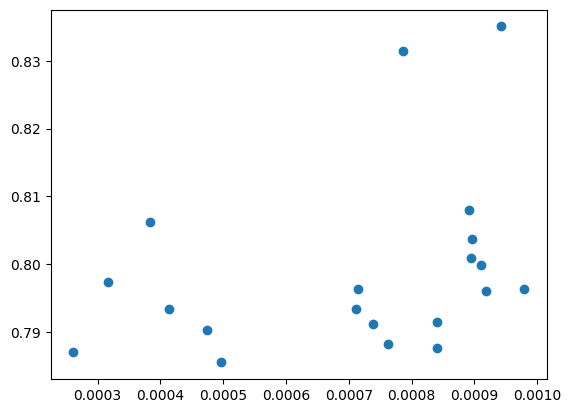

In [13]:
lr = dbvae.summary.loc[dbvae.summary.smoothing_fact=='1.4'].head(20)['learning_rate']
val = dbvae.summary.loc[dbvae.summary.smoothing_fact=='1.4'].head(20)['val_at_median']
plt.scatter([float(x) for x in lr], list(val))

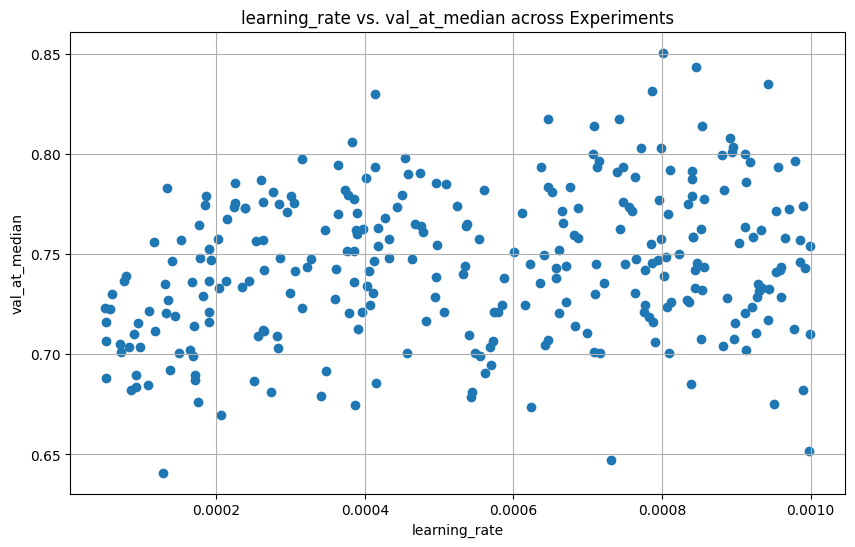

In [14]:
dbvae.plot_relation('learning_rate', 'val_at_median')

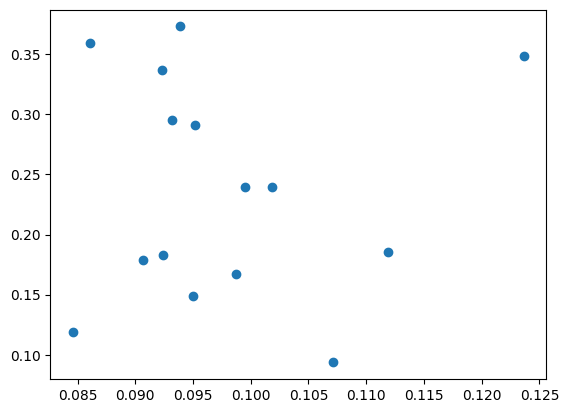

In [15]:
loss = dbvae.summary.loc[(dbvae.summary.smoothing_fact=='1')&(dbvae.summary.best_epoch==5)]['loss_at_median']
bias = dbvae.summary.loc[(dbvae.summary.smoothing_fact=='1')&(dbvae.summary.best_epoch==5)]['dbval_at_median']
plt.scatter(loss,bias)
plt.show()

standard cnn with 102 reps...
Processing dbvae smoothing=0.6 with 93 reps...
Processing dbvae smoothing=1 with 100 reps...
Processing dbvae smoothing=1.4 with 100 reps...


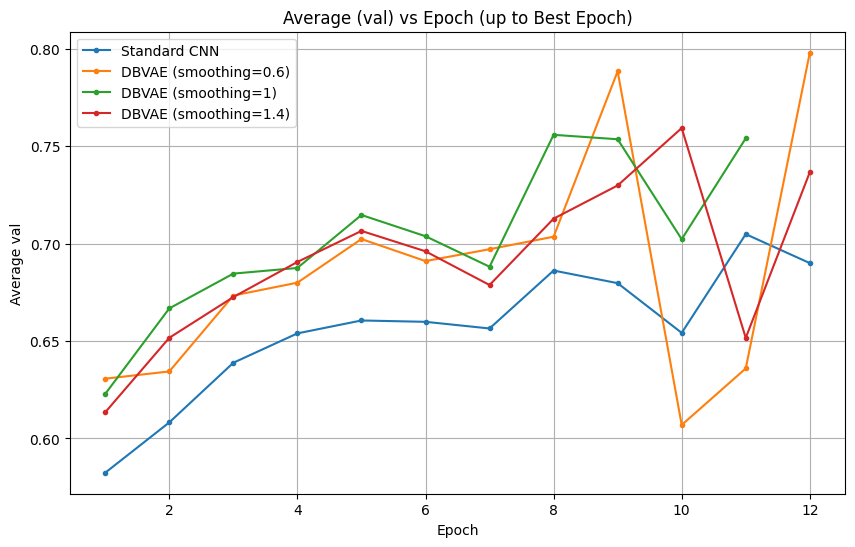

In [16]:
# Calculate average trajectories at each epoch across the experiments
metrix =  'val'

std_traj_dict = get_epoch_avg_history(standard, metrix)
dbvae_traj_dict = get_epoch_avg_history(dbvae, metrix)

# Plotting
plt.figure(figsize=(10, 6))

# --- Standard CNN: only one curve ---
std_traj = std_traj_dict.get('all', pd.Series(dtype=float))
if not std_traj.empty:
    plt.plot(std_traj.index + 1, std_traj.values,
             label='Standard CNN', marker='.')

# --- DBVAE: curves for each smoothing_fact ---
for sm_val, traj in dbvae_traj_dict.items():
    if traj is None or traj.empty:
        continue
    plt.plot(traj.index + 1, traj.values,
             label=f'DBVAE (smoothing={sm_val})', marker='.')

plt.xlabel('Epoch')
plt.ylabel(f'Average {metrix}')
plt.title(f'Average ({metrix}) vs Epoch (up to Best Epoch)')
plt.legend()
plt.grid(True)
plt.show()


In [17]:
dbvae_val =  get_epoch_avg_history(dbvae, 'val')
dbvae_dbval = get_epoch_avg_history(dbvae, 'dbval')

Processing dbvae smoothing=0.6 with 93 reps...
Processing dbvae smoothing=1 with 100 reps...
Processing dbvae smoothing=1.4 with 100 reps...
Processing dbvae smoothing=0.6 with 93 reps...
Processing dbvae smoothing=1 with 100 reps...
Processing dbvae smoothing=1.4 with 100 reps...


In [18]:
Vae = []
Dbvae = []

# Collect all trajectories and find the maximum length
all_vae_trajectories = [list(sm) for sm in dbvae_val.values()]
all_dbvae_trajectories = [list(sm) for sm in dbvae_dbval.values()]

max_len_vae = 0
if all_vae_trajectories:
    max_len_vae = max(len(t) for t in all_vae_trajectories)

max_len_dbvae = 0
if all_dbvae_trajectories:
    max_len_dbvae = max(len(t) for t in all_dbvae_trajectories)

# Pad shorter trajectories with NaN to match the maximum length
for traj in all_vae_trajectories:
    Vae.append(traj + [np.nan] * (max_len_vae - len(traj)))

for traj in all_dbvae_trajectories:
    Dbvae.append(traj + [np.nan] * (max_len_dbvae - len(traj)))

Vae = np.array(Vae)
Dbvae = np.array(Dbvae)
comb = Vae-2*Dbvae

In [19]:
std_val = get_epoch_avg_history(standard, 'val')
std_dbval = get_epoch_avg_history(standard, 'dbval')


standard cnn with 102 reps...
standard cnn with 102 reps...


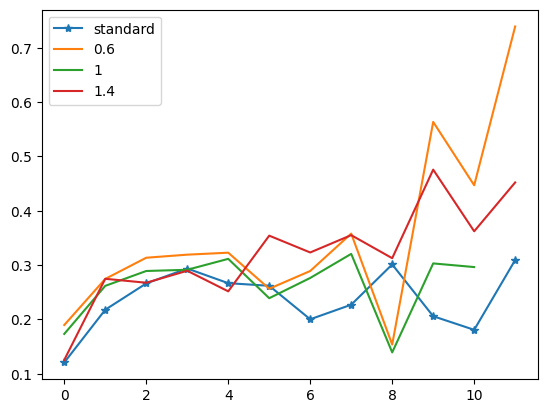

In [20]:
std_comb = std_val['all']-2*std_dbval['all']
plt.plot(std_comb, label = 'standard', marker = '*')
plt.plot(comb[0,:], label = '0.6')
plt.plot(comb[1,:],label = '1')
plt.plot(comb[2,:], label = '1.4')
plt.legend()
plt.show()